In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# jax
from jax import numpy as jnp
# numpy
import numpy as np
import random
import matplotlib.pyplot as plt
# utils
from tqdm.notebook import tqdm
import pickle
# custom modules
from canvas import *
from placer import *
from box import *
from net import *
from neuroPlacer import *
from VAEPlacer import *

## Pseudo Testcase Generation

number of boxes: 20 20
number of nets: 25 25
net_0 box_0 ['box_0', 'box_5', 'box_10', 'box_15']
net_1 box_1 ['box_1', 'box_6', 'box_11', 'box_16']
net_2 box_2 ['box_2', 'box_7', 'box_12', 'box_17']
net_3 box_3 ['box_3', 'box_8', 'box_13', 'box_18']
net_4 box_4 ['box_4', 'box_9', 'box_14', 'box_19']
net_6 box_0 ['box_0', 'box_1']
net_7 box_0 ['box_0', 'box_2']
net_8 box_0 ['box_0', 'box_3']
net_9 box_0 ['box_0', 'box_4']
net_10 box_1 ['box_1', 'box_0']
net_11 box_1 ['box_1', 'box_2']
net_12 box_1 ['box_1', 'box_3']
net_13 box_1 ['box_1', 'box_4']
net_14 box_2 ['box_2', 'box_0']
net_15 box_2 ['box_2', 'box_1']
net_16 box_2 ['box_2', 'box_3']
net_17 box_2 ['box_2', 'box_4']
net_18 box_3 ['box_3', 'box_0']
net_19 box_3 ['box_3', 'box_1']
net_20 box_3 ['box_3', 'box_2']
net_21 box_3 ['box_3', 'box_4']
net_22 box_4 ['box_4', 'box_0']
net_23 box_4 ['box_4', 'box_1']
net_24 box_4 ['box_4', 'box_2']
net_25 box_0 ['box_0', 'box_1', 'box_2', 'box_3', 'box_4']


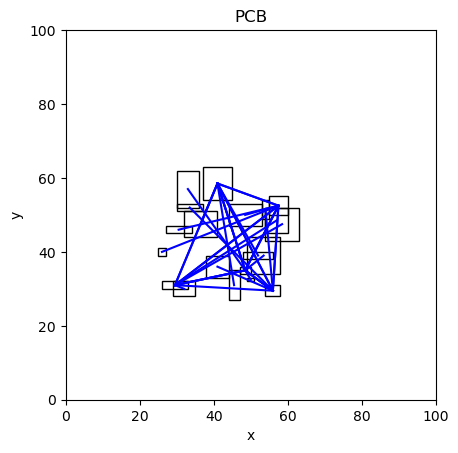

[[1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.
  1.]
 [0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0.
  1.]
 [0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1.
  1.]
 [0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0.
  1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1.
  1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [2]:
# make some boxes and nets
box_collection = {}
net_collection = {}

num_boxes = 20
num_nets = 5

# the first box of each net is the source box
source_box_collection = []

# generate 10 boxes and 3 nets
for i in range(0, num_boxes):
    net_idx = int(i % num_nets)
    box_collection[f"box_{i}"] = Box(
        box_name=f"box_{i}",
        llx=random.randint(25, 55),
        lly=random.randint(25, 55),
        width=random.randint(1, 10),
        height=random.randint(1, 10),
        net_name_list=[f"net_{net_idx}"],
    )

    if f"net_{net_idx}" not in net_collection:
        net_collection[f"net_{net_idx}"] = Net(
            net_name=f"net_{net_idx}", source_box_name=f"box_{i}", sink_box_names=[]
        )
        source_box_collection.append(f"box_{i}")
    else:
        net_collection[f"net_{net_idx}"].add_sink_box_name(f"box_{i}")
        
ADD_PAIRWISE_CONNECTIONS = True
if ADD_PAIRWISE_CONNECTIONS:
    net_idx = num_nets + 1
    # connect all the source boxes to each other
    for source_box_name in source_box_collection:
        for other_source_box_name in source_box_collection:
            if source_box_name != other_source_box_name:
                # create a new net
                net_collection[f"net_{net_idx}"] = Net(
                    net_name=f"net_{net_idx}", source_box_name=source_box_name, sink_box_names=[]
                )
                # add the other source box as a sink
                net_collection[f"net_{net_idx}"].add_sink_box_name(other_source_box_name)
                # add the net to the source box / other source box
                box_collection[source_box_name].add_net_name(f"net_{net_idx}")
                box_collection[other_source_box_name].add_net_name(f"net_{net_idx}")
                # increment the net index
                net_idx += 1

ADD_SUPER_CONNECTION = True
if ADD_SUPER_CONNECTION:
    net_idx = num_nets + num_boxes
    # connect all the source box to a super net
    net_collection[f"net_{net_idx}"] = Net(
        net_name=f"net_{net_idx}", source_box_name=source_box_collection[0], sink_box_names=[]
    )
    # add the net to the source box
    box_collection[source_box_collection[0]].add_net_name(f"net_{net_idx}")

    for source_box_name in source_box_collection:
        if source_box_name != source_box_collection[0]:
            net_collection[f"net_{net_idx}"].add_sink_box_name(source_box_name)
            box_collection[source_box_name].add_net_name(f"net_{net_idx}")


# make a canvas
pcb_canvas = PCBCanvas(width=100, height=100, boxes=box_collection, nets=net_collection)
print("number of boxes:", len(pcb_canvas.boxes), len(box_collection))
for box in pcb_canvas.boxes.values():
    print(box)
print("number of nets:", len(pcb_canvas.nets), len(net_collection))
for net in pcb_canvas.nets.values():
    print(net.net_name, net.source_box_name, net.box_names)

pcb_canvas.plot()

print(pcb_canvas.get_incidence_matrix())

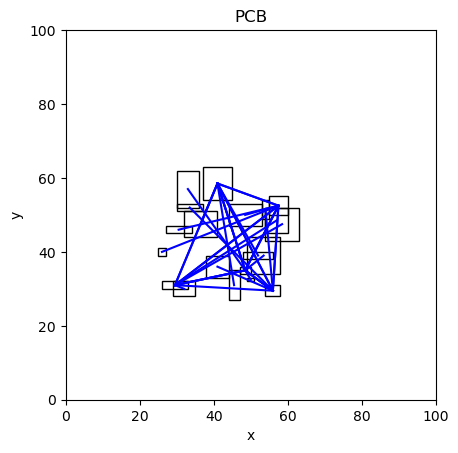

wirelength:	 830.7476906233042


In [3]:
# pickle the canvas
pickle_id = '10'
with open(f"./testcase/pcb_canvas_{pickle_id}.pkl", "wb") as f:
    pickle.dump(pcb_canvas, f)
# load the canvas
with open(f"./testcase/pcb_canvas_{pickle_id}.pkl", "rb") as f:
    pcb_canvas = pickle.load(f)

pcb_canvas.plot()
print("wirelength:\t", pcb_canvas.get_total_wirelength_from_cxy())

In [4]:
# extract the current canvas dimension
canvas_width = pcb_canvas.width
canvas_height = pcb_canvas.height
# canvas dimension (maxX, maxY, minX, minY)
canvas_dim = pcb_canvas.get_canvas_dim()
maxX, maxY, minX, minY = canvas_dim
compx = pcb_canvas.get_cxy()[:, 0]
compx_jnp = jnp.array(compx)

compy = pcb_canvas.get_cxy()[:, 1]
compy_jnp = jnp.array(compy)

comph = pcb_canvas.get_all_boxes_width()
comph_jnp = jnp.array(comph)

compw = pcb_canvas.get_all_boxes_height()
compw_jnp = jnp.array(compw)

num_bin_x = 10
num_bin_y = 10

# [Net to pin coord] mapping 
net_to_pin_coords = {}
for net in pcb_canvas.nets.values():
    for box_name in net.box_names:
        if net.net_name not in net_to_pin_coords:
            net_to_pin_coords[net.net_name] = [pcb_canvas.get_box_cxy(box_name)]
        else:
            net_to_pin_coords[net.net_name].append(pcb_canvas.get_box_cxy(box_name))

print("net to pin coords:")
for net, pin_coords in net_to_pin_coords.items():
    print(net, pin_coords)

# [Net to pin coord] mapping
net_to_insts = {}
for net in pcb_canvas.nets.values():
    net_to_insts[net.net_name] = net.box_names

print("net to insts:")
for net, insts in net_to_insts.items():
    print(net, insts)


net to pin coords:
net_0 [array([48.5, 35. ]), array([50. , 32.5]), array([33., 57.]), array([53.5, 39. ])]
net_1 [array([57.5, 52.5]), array([30.5, 46. ]), array([48.5, 50. ]), array([26., 40.])]
net_2 [array([41. , 58.5]), array([52., 39.]), array([45.5, 31. ]), array([36.5, 47.5])]
net_3 [array([29.5, 31. ]), array([57. , 48.5]), array([32., 30.]), array([58.5, 47.5])]
net_4 [array([56. , 29.5]), array([33.5, 52. ]), array([54. , 51.5]), array([41., 36.])]
net_6 [array([48.5, 35. ]), array([57.5, 52.5])]
net_7 [array([48.5, 35. ]), array([41. , 58.5])]
net_8 [array([48.5, 35. ]), array([29.5, 31. ])]
net_9 [array([48.5, 35. ]), array([56. , 29.5])]
net_10 [array([57.5, 52.5]), array([48.5, 35. ])]
net_11 [array([57.5, 52.5]), array([41. , 58.5])]
net_12 [array([57.5, 52.5]), array([29.5, 31. ])]
net_13 [array([57.5, 52.5]), array([56. , 29.5])]
net_14 [array([41. , 58.5]), array([48.5, 35. ])]
net_15 [array([41. , 58.5]), array([57.5, 52.5])]
net_16 [array([41. , 58.5]), array([29.5

# Placement Stage

wirelength:	 830.7476906233042


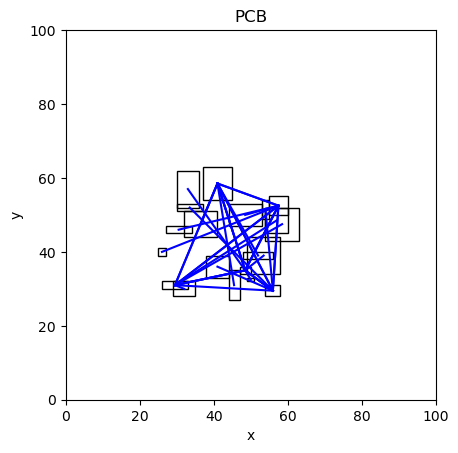

****************************************************
Weighted-average wirelength_2 grad:
 {'box_0': Array([ 0.7513262, -2.2757683], dtype=float32), 'box_5': Array([ 0.02999538, -0.04997924], dtype=float32), 'box_10': Array([-0.3051054 ,  0.42620438], dtype=float32), 'box_15': Array([0.09983349, 0.07991472], dtype=float32), 'box_1': Array([3.5939794, 2.9393287], dtype=float32), 'box_6': Array([-0.5148604 , -0.12963477], dtype=float32), 'box_11': Array([-0.17903253, -0.0499793 ], dtype=float32), 'box_16': Array([-0.59068   , -0.24742004], dtype=float32), 'box_2': Array([-1.4499137,  4.8662963], dtype=float32), 'box_7': Array([ 0.21823812, -0.3803346 ], dtype=float32), 'box_12': Array([ 0.08987859, -0.52347946], dtype=float32), 'box_17': Array([-0.0898788 , -0.21823797], dtype=float32), 'box_3': Array([-4.26193 , -2.738014], dtype=float32), 'box_8': Array([0.52347946, 0.3429833 ], dtype=float32), 'box_13': Array([ 0.04997927, -0.0199987 ], dtype=float32), 'box_18': Array([0.54905075, 0.32

In [5]:
# make a placer
pcbplacer = PCBPlacer(pcb_canvas)
pin_grad_to_inst = {} # aggregate the pin gradients for each instance

# init placement
# pcbplacer.init_plc_spectral()
print("wirelength:\t", pcb_canvas.get_total_wirelength_from_cxy())
pcb_canvas.plot()
WA_sum = 0
#### WA objective for each net
print("****************************************************")
print("Weighted-average wirelength_2 grad:\n", pcbplacer.Wa_obj_grad(
    net_to_pin_coords=net_to_pin_coords,
    net_to_insts=net_to_insts, SMOOTHNESS = 50))

print("HPWL objective grad: \n", pcbplacer.HPWL_obj_grad( net_to_pin_coords=net_to_pin_coords, net_to_insts=net_to_insts, verbose=False))


#### Density objective
print("****************************************************")
# print("Weighted-average wirelength_2:\n", pcbplacer.wirelength_objective_fn(
#     net_to_pin_coords=net_to_pin_coords,
#     net_to_insts=net_to_insts))
# print("Weighted-average wirelength_2 grad:\n", pcbplacer.wirelength_objective_fn_grad_jax(
#     net_to_pin_coords=net_to_pin_coords,
#     net_to_insts=net_to_insts, verbose=False))
print("Density objective: \n", pcbplacer.Grid_density_obj(
    compx_=compx,
    compy_=compy,
    compw_=compw,
    comph_=comph,
    canvas_dims=canvas_dim,
    num_bin_x=10,
    num_bin_y=10,
))

print("compx: ", compx)
print("compy: ", compy)
print("Density objective grad: \n", pcbplacer.Grid_density_obj_grad(
    compx_=compx_jnp,
    compy_=compy_jnp,
    compw_=compw_jnp,
    comph_=comph_jnp,
    canvas_dims=canvas_dim,
    num_bin_x=10,
    num_bin_y=10,
    verbose=True,
))

In [6]:
%%script false --no-raise-error
print("Before wirelength:\t", pcb_canvas.get_total_wirelength_from_cxy())
print(
    "Before density:\t",
    pcbplacer.Grid_density_obj(
        compx_=compx,
        compy_=compy,
        compw_=compw,
        comph_=comph,
        canvas_dims=canvas_dim,
        num_bin_x=10,
        num_bin_y=10,
    ),
)

# clear the plot folder
for f in os.listdir("./plot/grad_density/"):
    os.remove(os.path.join("./plot/grad_density/", f))

# iteratively update the placement with only density objective
for i in tqdm(range(0, 100)):
    # plot the canvas
    pcb_canvas.plot(savefig=True, filename=f"./plot/grad_density/placement_{i}.png")

    # compute the gradient
    density_grad = pcbplacer.Grid_density_obj_grad(
        compx_=compx,
        compy_=compy,
        compw_=compw,
        comph_=comph,
        canvas_dims=canvas_dim,
        num_bin_x=10,
        num_bin_y=10,
        verbose=False,
    )

    # update the placement
    for grad in density_grad.keys():
        cx, cy = pcb_canvas.get_box_cxy(grad)
        if_move_x, if_move_y = pcbplacer.check_boundary(
            cx,
            cy,
            pcb_canvas.get_box_width(grad),
            pcb_canvas.get_box_height(grad),
            100 * density_grad[grad][0],
            100 * density_grad[grad][1],
            minX,
            minY,
            maxX,
            maxY,
        )

        if if_move_x:
            cx -= 100 * density_grad[grad][0]
        if if_move_y:
            cy -= 100 * density_grad[grad][1]

        pcb_canvas.set_box_cxy(grad, cx, cy)

    # update net_to_pin_coords
    compx = pcb_canvas.get_cxy()[:, 0]
    compy = pcb_canvas.get_cxy()[:, 1]

print("After wirelength:\t", pcb_canvas.get_total_wirelength_from_cxy())
print(
    "After density:\t",
    pcbplacer.Grid_density_obj(
        compx_=compx,
        compy_=compy,
        compw_=compw,
        comph_=comph,
        canvas_dims=canvas_dim,
        num_bin_x=10,
        num_bin_y=10,
    ),
)

# generate the placement gif
pcb_canvas.generate_gif_from_plots("grad_density", "placement_density_grad.gif")

In [7]:
%%script false --no-raise-error
# print the wirelength
print("Before wirelength:\t", pcb_canvas.get_total_wirelength_from_cxy())
# clear the plot folder
for f in os.listdir("./plot/grad_HPWL/"):
    os.remove(os.path.join("./plot/grad_HPWL/", f))

# iterate only with Wa_obj_grad and update the location of the instances
for i in tqdm(range(0, 10)):
    # plot the canvas
    pcb_canvas.plot(savefig=True, filename=f"./plot/grad_HPWL/placement_{i}.png")

    # compute the gradient
    HPWL_grad = pcbplacer.HPWL_obj_grad(
        net_to_pin_coords=net_to_pin_coords, net_to_insts=net_to_insts
    )

    # print("HPWL_grad length:", len(HPWL_grad))
    for grad in HPWL_grad.keys():
        cx, cy = pcb_canvas.get_box_cxy(grad)
        pcb_canvas.set_box_cxy(
            grad, cx - 0.1 * HPWL_grad[grad][0], cy - 0.1 * HPWL_grad[grad][1]
        )

    # update net_to_pin_coords
    net_to_pin_coords = {}
    for net in pcb_canvas.nets.values():
        # print(net.net_name)
        for box_name in net.box_names:
            # print(box_name)
            if net.net_name not in net_to_pin_coords:
                net_to_pin_coords[net.net_name] = [pcb_canvas.get_box_cxy(box_name)]
            else:
                net_to_pin_coords[net.net_name].append(pcb_canvas.get_box_cxy(box_name))

    # print(net_to_pin_coords)

# print the wirelength
print("After wirelength:\t", pcb_canvas.get_total_wirelength_from_cxy())

pcb_canvas.generate_gif_from_plots("grad_HPWL", "placement_HPWL_grad.gif")

In [8]:
%%script false --no-raise-error
# print the wirelength
print("Before wirelength:\t", pcb_canvas.get_total_wirelength_from_cxy())
# clear the plot folder
for f in os.listdir("./plot/grad_Wa/"):
    os.remove(os.path.join("./plot/grad_Wa/", f))

# iterate only with Wa_obj_grad and update the location of the instances
for i in tqdm(range(0, 10)):
    # plot the canvas
    pcb_canvas.plot(savefig=True, filename=f"./plot/grad_Wa/placement_{i}.png")

    # compute the gradient
    Wa_obj_grad = pcbplacer.Wa_obj_grad(
        net_to_pin_coords=net_to_pin_coords, net_to_insts=net_to_insts, SMOOTHNESS = 50
    )

    for grad in Wa_obj_grad.keys():
        print(grad, Wa_obj_grad[grad])
        cx, cy = pcb_canvas.get_box_cxy(grad)
        pcb_canvas.set_box_cxy(
            grad, cx -  Wa_obj_grad[grad][0], cy -  Wa_obj_grad[grad][1]
        )

    # update net_to_pin_coords
    net_to_pin_coords = {}
    for net in pcb_canvas.nets.values():
        # print(net.net_name)
        for box_name in net.box_names:
            # print(box_name)
            if net.net_name not in net_to_pin_coords:
                net_to_pin_coords[net.net_name] = [pcb_canvas.get_box_cxy(box_name)]
            else:
                net_to_pin_coords[net.net_name].append(pcb_canvas.get_box_cxy(box_name))

    print(net_to_pin_coords)

# print the wirelength
print("After wirelength:\t", pcb_canvas.get_total_wirelength_from_cxy())

pcb_canvas.generate_gif_from_plots("grad_Wa", "placement_Wa_grad.gif")

## Gradient-based Placement 

In [9]:
# %%script false --no-raise-error
lambda_Density = 0.01
# print the wirelength
print("Before wirelength:\t", pcb_canvas.get_total_wirelength_from_cxy())

# clear the plot folder
for f in os.listdir("./plot/grad_09/"):
    os.remove(os.path.join("./plot/grad_09/", f))

prev_Wa_obj = pcbplacer.Wa_obj(
    net_to_pin_coords=net_to_pin_coords, net_to_insts=net_to_insts, SMOOTHNESS=50
)
prev_Density_obj = pcbplacer.Density_obj(
    compx_=compx,
    compy_=compy,
    compw_=compw,
    comph_=comph,
    canvas_dims=canvas_dim,
    num_bin_x=10,
    num_bin_y=10,
)

# iterate only with Wa_obj_grad & Density_obj_grad and update the location of the instances
for i in tqdm(range(0, 5000)):
    # plot the canvas
    pcb_canvas.plot(savefig=True, filename=f"./plot/grad_09/placement_{i}.png")

    # compute the gradient
    Wa_obj_grad = pcbplacer.Wa_obj_grad(
        net_to_pin_coords=net_to_pin_coords, net_to_insts=net_to_insts, SMOOTHNESS=50
    )
    Density_obj_grad = pcbplacer.Density_obj_grad(
        compx_=compx,
        compy_=compy,
        compw_=compw,
        comph_=comph,
        canvas_dims=canvas_dim,
        num_bin_x=10,
        num_bin_y=10,
        verbose=False,
    )

    # if nan density gradient, then set to 0
    for grad in Density_obj_grad.keys():
        if np.isnan(Density_obj_grad[grad][0]) or np.isnan(Density_obj_grad[grad][1]):
            Density_obj_grad[grad] = np.array([1e6, 1e6])

    # compute the gradient
    for Wa_grad, Density_grad in zip(Wa_obj_grad.keys(), Density_obj_grad.keys()):
        # print(grad, Wa_obj_grad[grad])
        cx, cy = pcb_canvas.get_box_cxy(Wa_grad)
        # dynamically scale the lambda_Density based on the scale of the Wa_obj_grad
        # lambda_Density = np.linalg.norm(Wa_obj_grad[Wa_grad]) / np.linalg.norm(Density_obj_grad[Density_grad])

        total_grad = -1 * (
            Wa_obj_grad[Wa_grad] + lambda_Density * Density_obj_grad[Density_grad]
        )

        if_move_x, if_move_y = pcbplacer.check_boundary(
            cx,
            cy,
            pcb_canvas.get_box_width(Wa_grad),
            pcb_canvas.get_box_height(Wa_grad),
            total_grad[0],
            total_grad[1],
            minX,
            minY,
            maxX,
            maxY,
        )
        # print(f"    [INFO] total_grad: {total_grad}, wa_grad: {Wa_obj_grad[Wa_grad]}, density_grad: {lambda_Density * Density_obj_grad[Density_grad]}")

        if if_move_x:
            cx += total_grad[0]
        if if_move_y:
            cy += total_grad[1]

        pcb_canvas.set_box_cxy(Wa_grad, cx, cy)

    # update net_to_pin_coords
    net_to_pin_coords = {}
    for net in pcb_canvas.nets.values():
        # print(net.net_name)
        for box_name in net.box_names:
            # print(box_name)
            if net.net_name not in net_to_pin_coords:
                net_to_pin_coords[net.net_name] = [pcb_canvas.get_box_cxy(box_name)]
            else:
                net_to_pin_coords[net.net_name].append(pcb_canvas.get_box_cxy(box_name))
    
    #update compx, compy
    compx = pcb_canvas.get_cxy()[:, 0]
    compy = pcb_canvas.get_cxy()[:, 1]

    # reevaluate the density objective
    Density_obj = pcbplacer.Density_obj(
        compx_=compx,
        compy_=compy,
        compw_=compw,
        comph_=comph,
        canvas_dims=canvas_dim,
        num_bin_x=10,
        num_bin_y=10,
    )

    # reevaluate the wirelength objective
    Wa_obj = pcbplacer.wirelength_objective_fn(
        net_to_pin_coords=net_to_pin_coords, net_to_insts=net_to_insts
    )

    print(f"    [INFO] Wa_obj: {Wa_obj}, Density_obj: {Density_obj}")

    # check the convergence
    if (
        abs(prev_Wa_obj - Wa_obj) < 100
        and abs(prev_Density_obj - Density_obj) < 100
    ):
        print("Converged!")
        break

    prev_Wa_obj = Wa_obj
    prev_Density_obj = Density_obj

    # print(net_to_pin_coords)

# print the wirelength
print("After wirelength:\t", pcb_canvas.get_total_wirelength_from_cxy())

pcb_canvas.generate_gif_from_plots("grad_09", "placement_09_grad.gif")

Future exception was never retrieved
future: <Future finished exception=BrokenPipeError(32, 'Broken pipe')>
Traceback (most recent call last):
  File "/home/projects/PointCloudPlacer/.conda/lib/python3.10/asyncio/unix_events.py", line 676, in write
    n = os.write(self._fileno, data)
BrokenPipeError: [Errno 32] Broken pipe


Before wirelength:	 830.7476906233042


/tmp/ipykernel_3772307/674176691.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(0, 5000)):


  0%|          | 0/5000 [00:00<?, ?it/s]

    [INFO] Wa_obj: 1213.6469962596893, Density_obj: 42212.12109375
    [INFO] Wa_obj: 982.5997774600983, Density_obj: 41206.59375
    [INFO] Wa_obj: 913.1564605236053, Density_obj: 32176.912109375
    [INFO] Wa_obj: 909.3693492412567, Density_obj: 33566.96484375
    [INFO] Wa_obj: 948.7368586063385, Density_obj: 32866.8828125
    [INFO] Wa_obj: 912.4877302646637, Density_obj: 39107.0390625
    [INFO] Wa_obj: 989.4020521640778, Density_obj: 39459.9453125
    [INFO] Wa_obj: 1043.6480691432953, Density_obj: 37863.7109375
    [INFO] Wa_obj: 1138.8163826465607, Density_obj: 29447.55078125
    [INFO] Wa_obj: 1179.3712179660797, Density_obj: 26543.59765625
    [INFO] Wa_obj: 1138.4114181995392, Density_obj: 26139.689453125
    [INFO] Wa_obj: 1100.2463674545288, Density_obj: 28583.6796875
    [INFO] Wa_obj: 1070.4146451950073, Density_obj: 23621.451171875
    [INFO] Wa_obj: 1042.6995708942413, Density_obj: 27792.28125
    [INFO] Wa_obj: 982.0407605171204, Density_obj: 24824.67578125
    [INFO]

In [10]:
pcb_canvas.generate_gif_from_plots("grad_09", "placement_09_grad.gif")